In [ ]:
!pip install pytorch-lightning lightning
!pip install pytorch
!pip install numpy
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import lightning as L
import copy as copy
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.metrics import classification_report


#encoding

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = nn.ModuleList([SublayerConnection(size, dropout) for _ in range(2)])
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(4)])
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = self.attention(query, key, value, mask)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

    def attention(self, query, key, value, mask=None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-1, -2)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        p_attn = self.dropout(p_attn)
        return torch.matmul(p_attn, value), p_attn

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=512, nhead=8, num_layers=2, d_ff=1024, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        attn = MultiHeadedAttention(nhead, d_model, dropout)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.encoder = Encoder(EncoderLayer(d_model, attn, ff, dropout), num_layers)
        self.output_fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.encoder(x, None)
        return self.output_fc(x)

Epoch 1/10, Loss: 0.7823
Epoch 2/10, Loss: 0.1435
Epoch 3/10, Loss: 0.0715
Epoch 4/10, Loss: 0.0634
Epoch 5/10, Loss: 0.0612
Epoch 6/10, Loss: 0.0649
Epoch 7/10, Loss: 0.0767
Epoch 8/10, Loss: 0.0742
Epoch 9/10, Loss: 0.0694
Epoch 10/10, Loss: 0.0691
Accuracy on test data: 0.8362


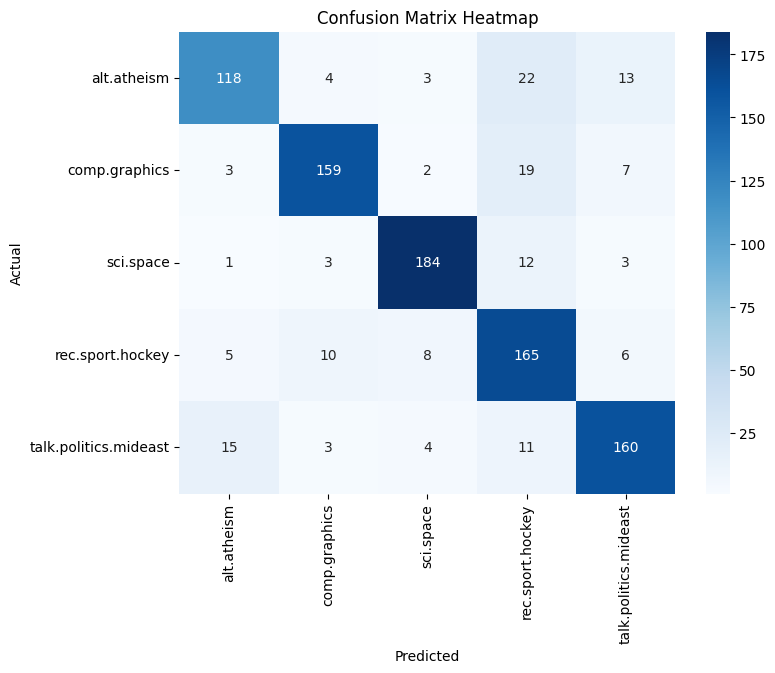

Confusion Matrix:
                       alt.atheism  comp.graphics  sci.space  \
alt.atheism                    118              4          3   
comp.graphics                    3            159          2   
sci.space                        1              3        184   
rec.sport.hockey                 5             10          8   
talk.politics.mideast           15              3          4   

                       rec.sport.hockey  talk.politics.mideast  
alt.atheism                          22                     13  
comp.graphics                        19                      7  
sci.space                            12                      3  
rec.sport.hockey                    165                      6  
talk.politics.mideast                11                    160  
Classification Report:
                       precision    recall  f1-score   support

          alt.atheism       0.83      0.74      0.78       160
        comp.graphics       0.89      0.84      0.86     

In [ ]:


categories = ["alt.atheism", "comp.graphics", "sci.space", "rec.sport.hockey", "talk.politics.mideast"]
dataset = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(dataset.data).toarray()
y = LabelEncoder().fit_transform(dataset.target)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=512, nhead=8, num_layers=2, d_ff=1024, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        attn = MultiHeadedAttention(nhead, d_model, dropout)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.encoder = Encoder(EncoderLayer(d_model, attn, ff, dropout), num_layers)
        self.output_fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.encoder(x, None)
        x = x.mean(dim=1)
        return self.output_fc(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(input_dim=5000, num_classes=len(categories)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        test_outputs = model(X_batch)
        predictions = torch.argmax(test_outputs, dim=1)
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)

    accuracy = correct / total


all_preds = []
all_labels = []

for X_batch, y_batch in test_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    test_outputs = model(X_batch)
    predictions = torch.argmax(test_outputs, dim=1)
    all_preds.extend(predictions.cpu().numpy())
    all_labels.extend(y_batch.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix_df = pd.DataFrame(conf_matrix, index=categories, columns=categories)

print(f"Accuracy on test data: {accuracy:.4f}")

classification_report_str = classification_report(all_labels, all_preds, target_names=categories)



plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

print("Confusion Matrix:")
print(conf_matrix_df)
print("Classification Report:")
print(classification_report_str)
